In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py
#from statsmodels.stats import shapiro
#from scipy.stats import shapiro
import scipy.stats

# allow multiple outputs in jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display to show all rows
pd.set_option('display.max_rows', None)

# set display to show all columns
pd.set_option("display.max.columns", None)

< DATA CLEANING AND PREPARATION (this is the version that keeps the variable names e.g. v001_rawvalue as the column name)
>

In [6]:
# import data into county_health_data data frame
county_health_data = pd.read_csv('county_health_2021.csv')

# rename headers using 1st row of data
county_health_data = county_health_data.rename(columns=county_health_data.iloc[0])

# delete 1st row (which is now a duplicate of the header)
county_health_data = county_health_data.drop(county_health_data.index[0])

dtype('float64')

dtype('float64')

dtype('float64')

dtype('float64')

dtype('float64')

dtype('float64')

In [7]:
# view first 5 rows of county_health_data data frame (note that there appears to be no index 0)
county_health_data.head()

,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,v001_cilow,v001_cihigh,v001_flag,v001_race_aian,v001_race_aian_cilow,v001_race_aian_cihigh,v001_race_aian_flag,v001_race_asian,v001_race_asian_cilow,v001_race_asian_cihigh,v001_race_asian_flag,v001_race_black,v001_race_black_cilow,v001_race_black_cihigh,v001_race_black_flag,v001_race_hispanic,v001_race_hispanic_cilow,v001_race_hispanic_cihigh,v001_race_hispanic_flag,v001_race_white,v001_race_white_cilow,v001_race_white_cihigh,v001_race_white_flag,v002_rawvalue,v002_numerator,v002_denominator,v002_cilow,v002_cihigh,v036_rawvalue,v036_numerator,v036_denominator,v036_cilow,v036_cihigh,v042_rawvalue,v042_numerator,v042_denominator,v042_cilow,v042_cihigh,v037_rawvalue,v037_numerator,v037_denominator,v037_cilow,v037_cihigh,v037_flag,v037_race_aian,v037_race_aian_cilow,v037_race_aian_cihigh,v037_race_asian,v037_race_asian_cilow,v037_race_asian_cihigh,v037_race_black,v037_race_black_cilow,v037_race_black_cihigh,v037_race_hispanic,v037_race_hispanic_cilow,v037_race_hispanic_cihigh,v037_race_white,v037_race_white_cilow,v037_race_white_cihigh,v009_rawvalue,v009_numerator,v009_denominator,v009_cilow,v009_cihigh,v011_rawvalue,v011_numerator,v011_denominator,v011_cilow,v011_cihigh,v133_rawvalue,v133_numerator,v133_denominator,v133_cilow,v133_cihigh,v070_rawvalue,v070_numerator,v070_denominator,v070_cilow,v070_cihigh,v132_rawvalue,v132_numerator,v132_denominator,v132_cilow,v132_cihigh,v049_rawvalue,v049_numerator,v049_denominator,v049_cilow,v049_cihigh,v134_rawvalue,v134_numerator,v134_denominator,v134_cilow,v134_cihigh,v045_rawvalue,v045_numerator,v045_denominator,v045_cilow,v045_cihigh,v014_rawvalue,v014_numerator,v014_denominator,v014_cilow,v014_cihigh,v014_race_aian,v014_race_aian_cilow,v014_race_aian_cihigh,v014_race_asian,v014_race_asian_cilow,v014_race_asian_cihigh,v014_race_black,v014_race_black_cilow,v014_race_black_cihigh,v014_race_hispanic,v014_race_hispanic_cilow,v014_race_hispanic_cihigh,v014_race_white,v014_race_white_cilow,v014_race_white_cihigh,v085_rawvalue,v085_numerator,v085_denominator,v085_cilow,v085_cihigh,primary_care_phys,v004_numerator,v004_denominator,v004_cilow,v004_cihigh,v004_other_data_1,v088_rawvalue,v088_numerator,v088_denominator,v088_cilow,v088_cihigh,v088_other_data_1,v062_rawvalue,v062_numerator,v062_denominator,v062_cilow,v062_cihigh,v062_other_data_1,v005_rawvalue,v005_numerator,v005_denominator,v005_cilow,v005_cihigh,v005_race_aian,v005_race_asian,v005_race_black,v005_race_hispanic,v005_race_white,v050_rawvalue,v050_numerator,v050_denominator,v050_cilow,v050_cihigh,v050_race_aian,v050_race_asian,v050_race_black,v050_race_hispanic,v050_race_white,v155_rawvalue,v155_numerator,v155_denominator,v155_cilow,v155_cihigh,v155_race_aian,v155_race_asian,v155_race_black,v155_race_hispanic,v155_race_white,v168_rawvalue,v168_numerator,v168_denominator,v168_cilow,v168_cihigh,v069_rawvalue,v069_numerator,v069_denominator,v069_cilow,v069_cihigh,v023_rawvalue,v023_numerator,v023_denominator,v023_cilow,v023_cihigh,v024_rawvalue,v024_numerator,v024_denominator,v024_cilow,v024_cihigh,v024_race_aian,v024_race_aian_cilow,v024_race_aian_cihigh,v024_race_asian,v024_race_asian_cilow,v024_race_asian_cihigh,v024_race_black,v024_race_black_cilow,v024_race_black_cihigh,v024_race_hispanic,v024_race_hispanic_cilow,v024_race_hispanic_cihigh,v024_race_white,v024_race_white_cilow,v024_race_white_cihigh,income_inequality,v044_numerator,v044_denominator,v044_cilow,v044_cihigh,v082_rawvalue,v082_numerator,v082_denominator,v082_cilow,v082_cihigh,v140_rawvalue,v140_numerator,v140_denominator,v140_cilow,v140_cihigh,v043_rawvalue,v043_numerator,v043_denominator,v043_cilow,v043_cihigh,v135_rawvalue,v135_numerator,v135_denominator,v135_cilow,v135_cihigh,v135_race_aian,v135_race_aian_cilow,v135_race_aian_cihigh,v135_race_asian,v135_race_asian_cilow,v135_race_asian_cihigh,v135_race_black,v135_race_black_cilow,v135_race_black_cihigh,v135_rac

In [ ]:
# rename broadband, uninsured adults, income inequality, primary care physicians, home ownership variables
county_health_data.rename(columns={"v166_rawvalue": "broadband_pct", "v003_rawvalue": "uninsured_adults_pct",\
                                  "v044_rawvalue": "income_inequality", "v004_rawvalue": "primary_care_phys",\
                                  "v153_rawvalue": "home_ownership" }, inplace=True)

# determine data type of above variables and fipscode (all are objects)
county_health_data['broadband_pct'].dtypes
county_health_data['uninsured_adults_pct'].dtypes
#county_health_data['income_inequality'].dtypes
county_health_data['primary_care_phys'].dtypes
county_health_data['home_ownership'].dtypes
county_health_data['fipscode'].dtypes

# convert data type of all above variables from object to float
county_health_data['broadband_pct'] = county_health_data['broadband_pct'].astype(float)
county_health_data['uninsured_adults_pct'] = county_health_data['uninsured_adults_pct'].astype(float)
county_health_data['income_inequality'] = county_health_data['income_inequality'].astype(float)
county_health_data['primary_care_phys'] = county_health_data['primary_care_phys'].astype(float)
county_health_data['home_ownership'] = county_health_data['home_ownership'].astype(float)
county_health_data['fipscode'] = county_health_data['fipscode'].astype(float)

In [8]:
## BASIC STATS

# total number of null values in each column
#county_health_data.isna().sum()

# number of rows and columns in county_health_data (rows: 3194, columns: 690)
county_health_data.shape

# display all columns and their data types (says that all 690 columns are of data type 'object' aka Pandas doesn't recognize the data type)
#county_health_data.info()

# display basic descriptive statistics 
#county_health_data.describe(include=object)

(3194, 690)

In [2]:
## JOINT EXCESS DEATHS AND COUNTY HEALTH RANKINGS ANALYSIS

# import data into excess deaths data frame
excess_deaths = pd.read_csv('ExcessDeaths_Obesity.csv')

In [3]:
excess_deaths.head()

,OBJECTID_1,ID,CountyName,State,TOTPOP_CY,Deaths,Expected,Abnormal,Excess,COVID19,Unknown,Shape_Leng,IDFLOAT,FID_1,OBJECTID,FIPS_BEA,Shape_Le_1,Shape_Area,OBJECTID_2,FIPS_NUM,FIPS,STATE_1,ST_ABBR,COUNTY,LOCATION,SVI_RANK,risk_score,Covid_EVI,EVI_Rank,CASESPER10,DIFFPREVDA,DIFFPREV_1,PctUnemplo,population,populati_1,per_pop_ov,over_60_pe,icu_beds,positives,hospitals,licensed_b,staffed_be,deaths_1,Rating_Com,Rating_FWS,Rating_Haz,Rating_Hea,Rating_Ene,Rating_Saf,Rating_Tra,Pct_Diabet,HeartHospR,Pct_Obesit,Pct_Inacti,PM25_2014,UrbanRural,FoodInsRat,CASEDENSIT,POSITIVITY,INFECTIONR
0,1,1001,Autauga County,AL,57692,404,387,17,17,28,0,2.105121e+05,1001.0,1532,1,1001.0,2.015303,0.150257,0,0,0,NaN,NaN,NaN,NaN,0.0000,0.00000,0.00,0,0.000000,0,0.000000,0.0,0,0,0.0,NaN,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,0.000000,0.0000,0.000000
1,2,1003,Baldwin County,AL,219443,1775,1841,-66,0,94,0,1.543579e+06,1003.0,1533,2,1003.0,4.243962,0.409825,0,0,0,NaN,NaN,NaN,NaN,0.0000,0.00000,0.00,0,0.000000,0,0.000000,0.0,0,0,0.0,NaN,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,0.000000,0.0000,0.000000
2,3,1005,Barbour County,AL,27401,220,232,-12,0,16,0,2.720362e+05,1005.0,0,3,1005.0,2.441082,0.223192,566,1005,1005,ALABAMA,AL,Barbour,"Barbour County, Alabama",0.9959,0.30940,87.78,1455,4431.070152,3,0.255319,7.8,24881,4832,23.5,1230.0,5,1318,1,74,30,30,9.0,5.0,9.0,5.0,7.0,6.0,9.0,15.7,221.0,44.7,27.4,11.5,4,0.219,31.249638,0.1605,0.959807
3,4,1007,Bibb County,AL,23276,155,196,-41,0,19,0,1.908503e+05,1007.0,1,4,1007.0,1.893893,0.156433,567,1007,1007,ALABAMA,AL,Bibb,"Bibb County, Alabama",0.6003,0.09933,69.94,2398,5199.321828,8,0.673401,5.8,22400,3690,21.1,NaN,4,1577,1,35,25,42,9.0,5.0,9.0,5.0,7.0,6.0,9.0,13.3,222.7,37.9,34.1,11.2,2,0.151,114.188750,0.2741,1.236875
4,5,1009,Blount County,AL,59231,397,541,-144,0,12,0,2.422701e+05,1009.0,1534,5,1009.0,2.334544,0.164441,0,0,0,NaN,NaN,NaN,NaN,0.0000,0.00000,0.00,0,0.000000,0,0.000000,0.0,0,0,0.0,NaN,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,0.000000,0.0000,0.000000


<ipython-input-14-26e0580e9f3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==0] = 1


(array([ 13.,  33.,  41.,  42.,  79., 103.,  80.,  64.,  25.,   4.]),
 array([0.69314718, 1.57101827, 2.44888937, 3.32676046, 4.20463156,
        5.08250265, 5.96037375, 6.83824484, 7.71611594, 8.59398703,
        9.47185812]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Distribution of Excess Deaths')

Text(0.5, 0, 'Log(excess deaths)')

Text(0, 0.5, 'Frequency')

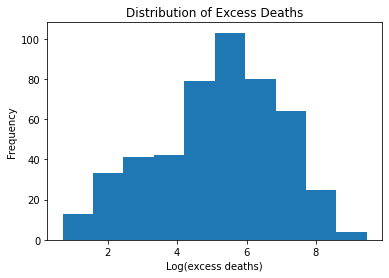

In [14]:
y = excess_deaths['Excess']

# convert all excess death values that are 0 to 1
y[y==0] = 1

# remove all rows that = 1
y = y[y!= 1]

# plot histogram of log y
plt.hist(np.log(y))

# add title and axis labels

plt.title('Distribution of Excess Deaths')
plt.xlabel('Log(excess deaths)')
plt.ylabel('Frequency')

plt.savefig('available excess deaths data.png')

In [11]:
y.shape

(484,)

In [16]:
import geopandas as gpd

In [17]:
counties = gpd.read_file('county_files/tl_2021_us_county.shp')

In [18]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350..."


In [4]:
# inner join excess covid deaths dataframe with county health dataframe
excess_county_health = pd.merge(county_health_data,excess_deaths,left_on='fipscode',right_on='ID')

# rename excess deaths column
excess_county_health.rename(columns={'Excess': 'excess_deaths'}, inplace=True)

# check data type of Excess column
excess_county_health['excess_deaths'].dtypes

NameError: name 'county_health_data' is not defined

In [45]:
# import google street view file
gsv = pd.read_csv('gsv_indicators_summarized_county.csv')

AttributeError: module 'geopandas' has no attribute 'read_csv'

In [20]:
#gsv.head()
gsv.shape

(2980, 9)

In [22]:
gsv['county'].dtypes

dtype('int64')

In [24]:
counties['GEOID'] = counties['GEOID'].astype(int)

In [25]:
# Merge counties and gsv_features
gsv_counties = pd.merge(gsv, counties, left_on='county', right_on='GEOID')

In [30]:
gsv_counties.head()

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,1001,0.969148,0.005288,0.089308,0.677698,0,0.343879,0.085365,0.083976,01,001,00161526,1001,Autauga,Autauga County,06,H1,G4020,388,33860,None,A,1539634184,25674812,+32.5322367,-086.6464395,"POLYGON ((-86.58826 32.36775, -86.58834 32.367..."
1,1003,0.947018,0.007764,0.116095,0.677067,0,0.436140,0.108644,0.097183,01,003,00161527,1003,Baldwin,Baldwin County,06,H1,G4020,380,19300,None,A,4117656514,1132955729,+30.6592183,-087.7460666,"POLYGON ((-87.61542 31.04100, -87.61542 31.040..."
2,1005,0.978433,0.004444,0.102145,0.665148,0,0.277878,0.043388,0.071833,01,005,00161528,1005,Barbour,Barbour County,06,H1,G4020,None,21640,None,A,2292160149,50523213,+31.8702531,-085.4051035,None
3,1007,0.992821,0.002094,0.046022,0.732843,0,0.242073,0.035595,0.054354,01,007,00161529,1007,Bibb,Bibb County,06,H1,G4020,142,13820,None,A,1612188717,9572303,+33.0158929,-087.1271475,None
4,1009,0.972386,0.002662,0.115099,0.674392,0,0.358319,0.032216,0.087506,01,009,00161530,1009,Blount,Blount County,06,H1,G4020,142,13820,None,A,1670259090,14860281,+33.9773575,-086.5664400,"POLYGON ((-86.56421 33.80194, -86.56556 33.801..."


In [47]:
gsv_counties_subset = gsv_counties[['prop_green', 'geometry']]

In [48]:
gsv_counties_subset.head()

,prop_green,geometry
0,0.969148,"POLYGON ((-86.58826 32.36775, -86.58834 32.367..."
1,0.947018,"POLYGON ((-87.61542 31.04100, -87.61542 31.040..."
2,0.978433,None
3,0.992821,None
4,0.972386,"POLYGON ((-86.56421 33.80194, -86.56556 33.801..."


In [54]:
from geopandas import GeoDataFrame

In [55]:
gsv_counties = GeoDataFrame(gsv_counties)

In [56]:
type(gsv_counties)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

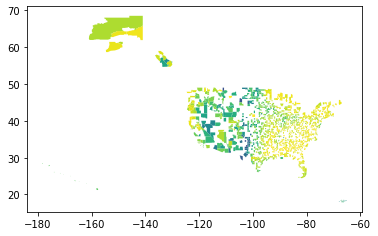

In [57]:
gsv_counties.plot(column='prop_green')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of County That Is Not Single Family Houses')

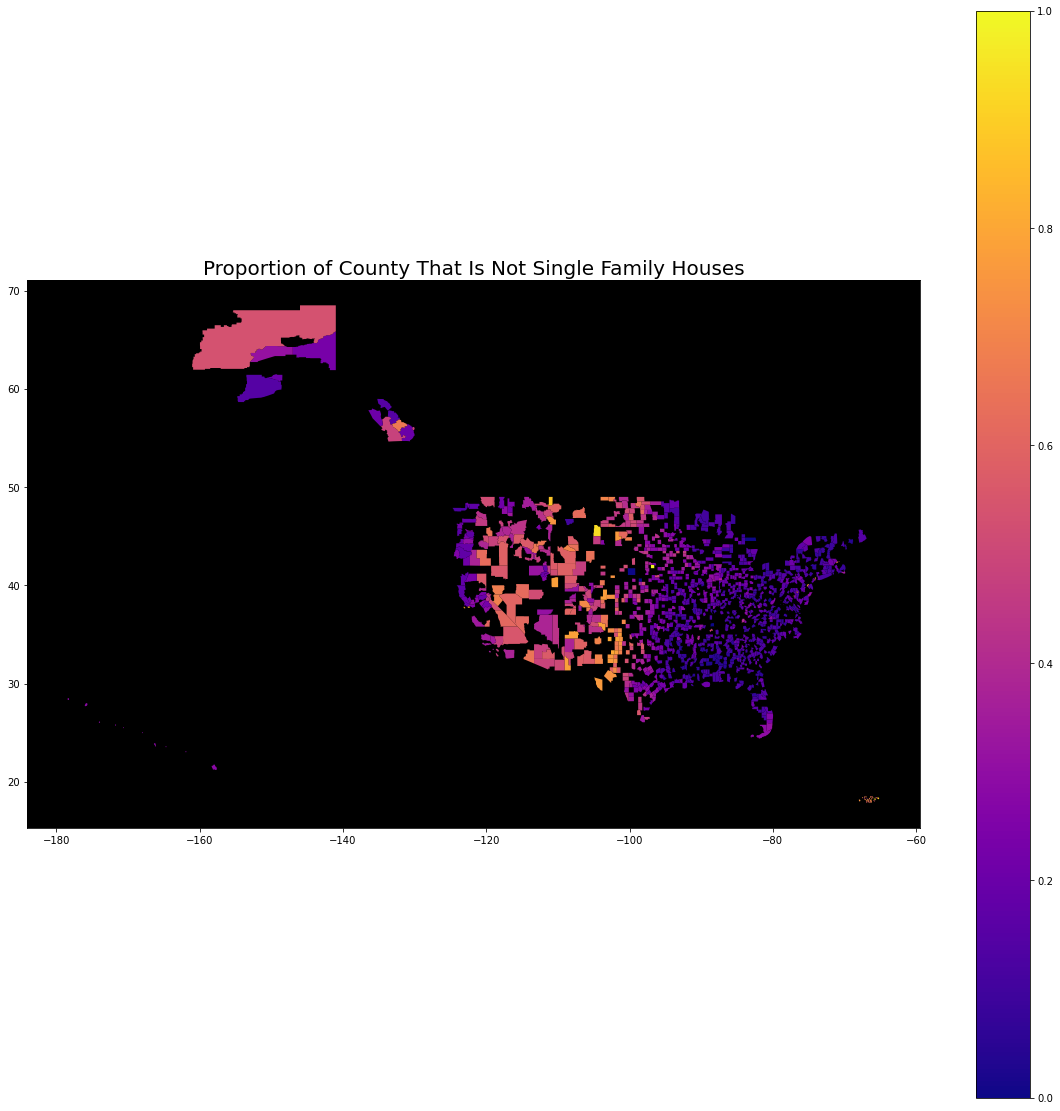

In [65]:
f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_not_single_family_house', ax=ax, cmap='plasma', legend=True)
ax.set_facecolor('k')

# add title
plt.title('Proportion of County That Is Not Single Family Houses', fontsize=20)

plt.savefig('not_single_family_homes.png')

In [61]:
gsv_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2979 entries, 0 to 2978
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   county                        2979 non-null   int64   
 1   prop_green                    2979 non-null   float64 
 2   prop_crosswalk                2979 non-null   float64 
 3   prop_not_single_family_house  2979 non-null   float64 
 4   prop_single_lane              2979 non-null   float64 
 5   prop_triple_lane              2979 non-null   int64   
 6   prop_visible_wires            2979 non-null   float64 
 7   prop_sidewalk                 2979 non-null   float64 
 8   prop_dilapidated_building     2979 non-null   float64 
 9   STATEFP                       2979 non-null   object  
 10  COUNTYFP                      2979 non-null   object  
 11  COUNTYNS                      2979 non-null   object  
 12  GEOID                         2979 non-n